# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

Index(['Year', 'Revenue', 'Change'], dtype='object')
   Year  Revenue  Change
0  2024    97.15    0.39
1  2023    96.77   18.80
2  2022    81.46   51.35
3  2021    53.82   70.67
4  2020    31.53   28.31


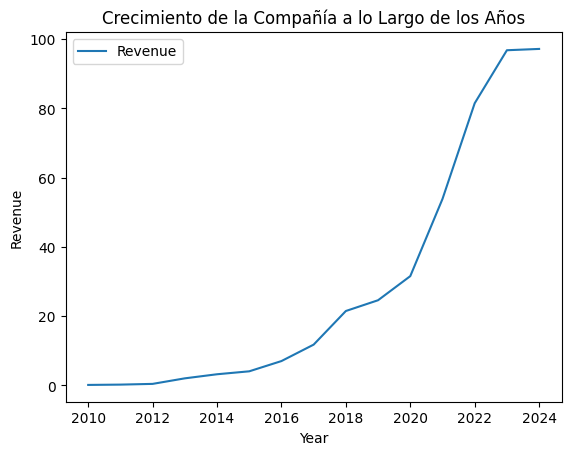

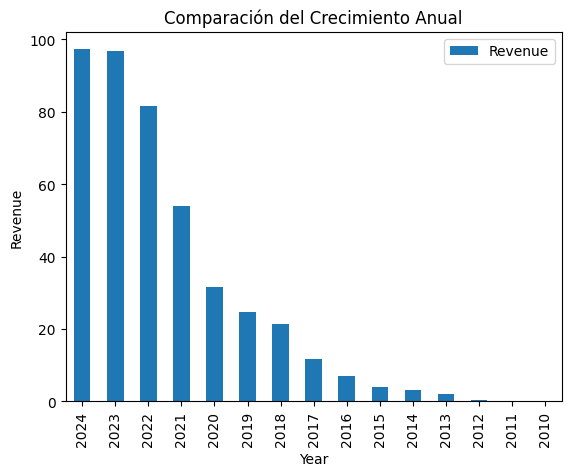

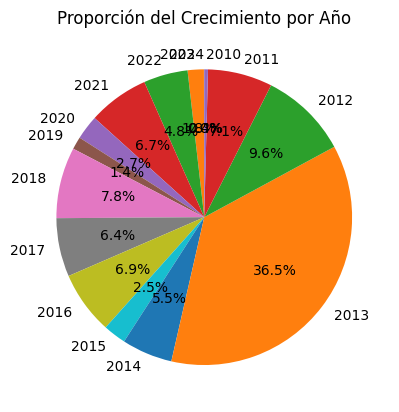

In [3]:
import requests
from io import StringIO
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Paso 2: Descargar HTML
url = "https://companies-market-cap-copy.vercel.app/index.html"
response = requests.get(url)
html_content = response.text

# Paso 3: Transformar el HTML
soup = BeautifulSoup(html_content, 'html.parser')
tables = soup.find_all('table')

# Suponiendo que la tabla con la evolución anual es la primera tabla
annual_growth_table = tables[0]
df = pd.read_html(StringIO(str(annual_growth_table)))[0]

# Paso 4: Procesar el DataFrame
df.columns = df.columns.str.strip()
df = df.apply(lambda x: x.str.replace('$', '').str.replace('B', '').str.strip() if x.dtype == "object" else x)
df.dropna(inplace=True)

# Convertir columnas a numéricas
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')
df['Change'] = df['Change'].str.replace('%', '').astype(float)
df.dropna(subset=['Year', 'Revenue', 'Change'], inplace=True)

# Verificar nombres de columnas y primeros registros
print(df.columns)  # Esto debería imprimir: Index(['Year', 'Revenue', 'Change'], dtype='object')
print(df.head())

# Paso 5: Almacenar los datos en sqlite
# Conectar a la base de datos (o crearla si no existe)
conn = sqlite3.connect('company_growth.db')

# Crear un cursor para ejecutar consultas SQL
cursor = conn.cursor()

# Crear la tabla 'annual_growth'
cursor.execute('''
CREATE TABLE IF NOT EXISTS annual_growth (
    Year INTEGER,
    Revenue REAL,
    Change REAL
)
''')

# Insertar los valores del DataFrame en la tabla
for index, row in df.iterrows():
    cursor.execute('''
    INSERT INTO annual_growth (Year, Revenue, Change)
    VALUES (?, ?, ?)
    ''', (row['Year'], row['Revenue'], row['Change']))

# Guardar (commit) los cambios
conn.commit()

# Cerrar la conexión
conn.close()

# Paso 6: Visualizar los datos
# Gráfico de líneas para Revenue
df.plot(x='Year', y='Revenue', kind='line')
plt.title('Crecimiento de la Compañía a lo Largo de los Años')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

# Gráfico de barras para Revenue
df.plot(x='Year', y='Revenue', kind='bar')
plt.title('Comparación del Crecimiento Anual')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

# Gráfico de pastel para Change
df.set_index('Year')['Change'].plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Proporción del Crecimiento por Año')
plt.ylabel('')
plt.show()